# Clustering

En este tutorial aprenderemos a trabajar técnicas de clustering. En el tutorial veremos distintos modelos:
- Basados en particiones: K-Medias, K-medoids.
- Métodos jerárquicos.
- Basados en densidad: DBSCAN



# Kmeans

En este ejemplo, vamos a generar un conjunto de muestras aleatorias. Comenzamos a generar estos datos

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score, silhouette_samples

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

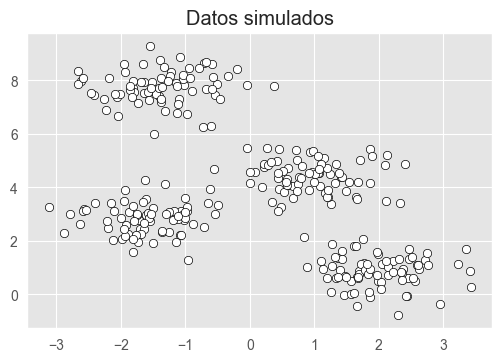

In [2]:
# Simulación de datos
# ==============================================================================
X, y = make_blobs(
    n_samples    = 300,
    n_features   = 2,
    centers      = 4,
    cluster_std  = 0.60,
    shuffle      = True,
    random_state = 0
)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = 'white',
    marker    = 'o',
    edgecolor = 'black',
)
ax.set_title('Datos simulados');

La implementación de `sklearn.cluster.KMeans` tiene los siguientes parámetros:
- `n_clusters`: determina el número *𝐾* de clusters que se van a generar.
- `init`: estrategia para asignar los centroides iniciales. Por defecto se emplea 'k-means++', una estrategia que trata de alejar los centroides lo máximo posible facilitando la convergencia. Sin embargo, esta estrategia puede ralentizar el proceso cuando hay muchos datos, si esto ocurre, es mejor utilizar 'random'.
- `n_init`: determina el número de veces que se va a repetir el proceso, cada vez con una asignación aleatoria inicial distinta. Es recomendable que este último valor sea alto, entre 10-25, para no obtener resultados subóptimos debido a una iniciación poco afortunada del proceso.
- `max_iter`: número máximo de iteraciones permitidas.
- `random_state`: semilla para garantizar la reproducibilidad de los resultados.

In [3]:
# Escalado de datos
# ==============================================================================
X_scaled = scale(X)

In [4]:
# Modelo
# ==============================================================================
modelo_kmeans = KMeans(n_clusters=4, n_init=25, random_state=42)
modelo_kmeans.fit(X=X_scaled)

KMeans(n_clusters=4, n_init=25, random_state=42)

El objeto devuelto por `KMeans()` contiene entre otros datos: la media de cada una de las variables para cada cluster (`cluster_centers_`), es decir, los centroides. Un vector indicando a qué cluster se ha asignado cada observación (`.labels_`) y la suma total de cuadrados internos de todos los clusters (`.inertia_`).

Vamos a pintar como nos quedan los clusters

In [5]:
# Clasificación con el modelo kmeans
# ==============================================================================
y_predict = modelo_kmeans.predict(X=X_scaled)

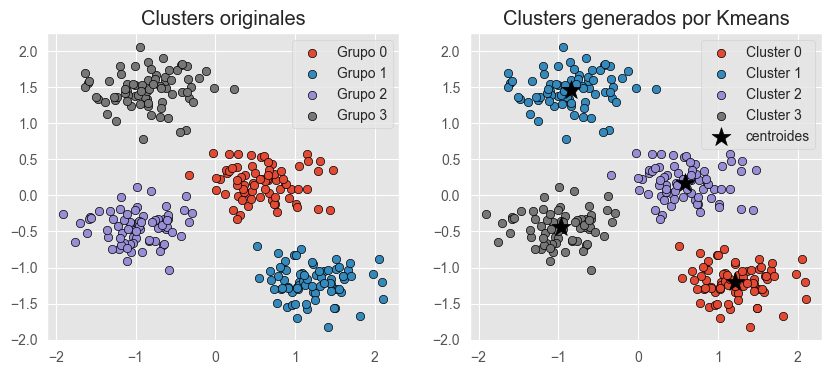

In [6]:
# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Grupos originales
for i in np.unique(y):
    ax[0].scatter(
        x = X_scaled[y == i, 0],
        y = X_scaled[y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Grupo {i}"
    )

ax[0].set_title('Clusters originales')
ax[0].legend();

for i in np.unique(y_predict):
    ax[1].scatter(
        x = X_scaled[y_predict == i, 0],
        y = X_scaled[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax[1].scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax[1].set_title('Clusters generados por Kmeans')
ax[1].legend();

Podemos ver también el número de aciertos y errores. Podemos verlo como una matriz de confusión. Aquí hay que tener cuidado que Kmeans asigna un cluster cuyo número puede ser distinto. Por lo tanto, cada fila tiene que tener un número alto (aciertos) y en las demás posiciones valores bajos (errores de clasificación)

In [7]:
# Matriz de confusión: grupos originales vs clusters creados
# ==============================================================================
pd.crosstab(y, y_predict, dropna=False, rownames=['grupo_real'], colnames=['cluster'])

cluster,0,1,2,3
grupo_real,,,,
0,0,0,75,0
1,75,0,0,0
2,0,0,0,75
3,0,75,0,0


Vamos a ver que pasaría si en vez de decirle a KMeans que son 4 clusters, le decimos que K=2 ó K=6

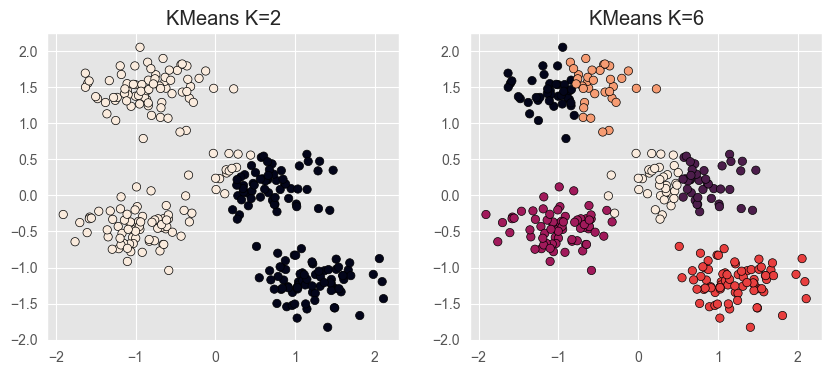

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Resultados para K = 2
# ==============================================================================
y_predict = KMeans(n_clusters=2, n_init=25, random_state=123).fit_predict(X=X_scaled)
ax[0].scatter(
    x = X_scaled[:, 0],
    y = X_scaled[:, 1],
    c = y_predict,
    #cmap='viridis',
    marker    = 'o',
    edgecolor = 'black'
)
ax[0].set_title('KMeans K=2');

# Resultados para K = 6
# ==============================================================================
y_predict = KMeans(n_clusters=6, n_init=25, random_state=123).fit_predict(X=X_scaled)
ax[1].scatter(
    x = X_scaled[:, 0],
    y = X_scaled[:, 1],
    c = y_predict,
    #cmap='viridis',
    marker    = 'o',
    edgecolor = 'black'
)
ax[1].set_title('KMeans K=6');

## Número de clusters

### Método del codo (Elbow method)
La solución al problema anterior es hacer una búsqueda de cual sería el K mejor. La idea es obtener para valor de K la suma de los cuadrados de la distancia de cada punto con el centroide al que se encuentra asignado (se obtiene de `.inertia_`). Es una medida de lo coherentes que son internamente los clusters. La idea es que si K crece el valor de `.inertia_` es menor porque cada cluster es más pequeño. Sin embargo, a partir de cierto punto, la adición de más clusters proporciona rendimientos decrecientes en términos de reducción de `.inertia_`, y la tasa de disminución se ralentiza, formando un codo en el gráfico. Ese sería el valor óptimo para seleccionar.

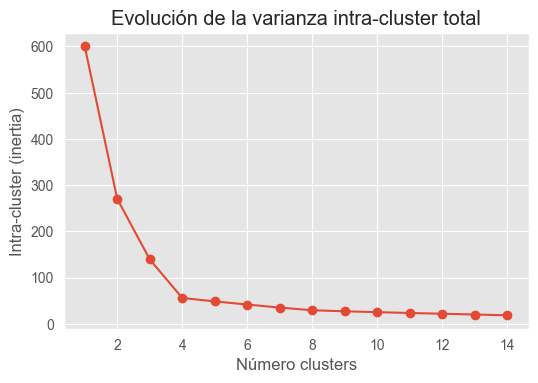

In [9]:
# Método elbow para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 42
    )
    modelo_kmeans.fit(X_scaled)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

Vemos como el valor óptimo es K=4, como ya sabíamos.

### Método Silhouette
Algunas veces, con el método Elbow es difícil determinar en número óptimo de clusters. Otra aproximación es el método Silhouette. Utiliza la distancia media intraclúster y la distancia media clúster más cercano para cada muestra. Cuanto mayor sea el valor de la puntuación, mejor será la estimación. Normalmente, las puntuaciones de silhoutte suben y luego bajan hasta alcanzar un número óptimo de clusters. Los valores se sitúan entre -1,0 y 1,0.

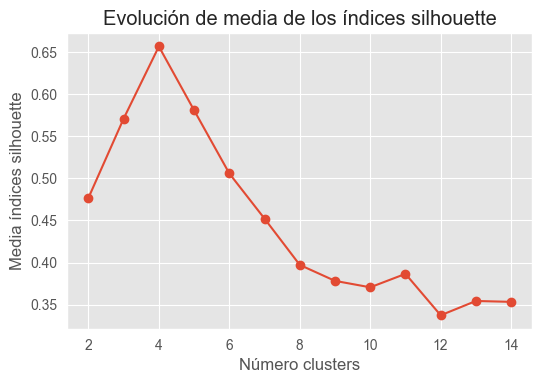

In [10]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 123
    )
    cluster_labels = modelo_kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

En este ejemplo se utiliza el análisis de silhouette para elegir un valor óptimo para n_clusters. El gráfico de silhouette muestra que los valores n_clusters de 3, 5 y 6 son una mala elección para los datos dados.

# Cluster jerárquico

Usaremos el dataset USArrests que contiene estadísticas sobre arrestos por cada 100,000 residentes por asalto, asesinato y violación en cada uno de los 50 estados de EE. UU. en 1973. También se da el porcentaje de la población que vive en áreas urbanas.

In [15]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

Datos

In [16]:
USArrests = sm.datasets.get_rdataset("USArrests", "datasets")
USArrests['StateAbbrv'] = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT","DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ","NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC","SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

datos = USArrests.data
datos.head(4)

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>

Los escalamos

In [ ]:
# Escalado de las variables
# ==============================================================================
datos_scaled = scale(X=datos, axis=0, with_mean=True, with_std=True)
datos_scaled = pd.DataFrame(datos_scaled, columns=datos.columns, index=datos.index)
datos_scaled.head(4)

In [ ]:
def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

Los parámetros de la clase `sklearn.cluster.AgglomerativeClustering` que destacan:

- `n_clusters`: determina el número de clusters que se van a generar. En su lugar, su valor puede ser None si se quiere utilizar el criterio `distance_threshold` para crear los clusters o crecer todo el dendograma.
- `distance_threshold`: distancia (altura del dendograma) a partir de la cual se dejan de unir los clusters. Indicar `distance_threshold=0` para crecer todo el árbol.
- `compute_full_tree`: si se calcula la jerarquía completa de clusters. Debe ser `True` si `distance_threshold` es distinto de `None`.
- `affinity`: métrica utilizada como distancia. Puede ser: “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”. Si se utiliza `linkage=“ward”`, solo se permite “euclidean”.
- `linkage: tipo de linkage utilizado. Puede ser “ward”, “complete”, “average” o “single”.

Al aplicar un hierarchical clustering aglomerativo se tiene que escoger una medida de distancia y un tipo de linkage. El concepto de linkage contempla la forma que tenemos de medir la distancia entre pares de grupos. Tenemos varias formas:
- `"ward"`. La elección de los pares de clusters que se fusionan en cada etapa del *agglomerative hierarchical clustering* se fundamenta en el valor óptimo de una función objetivo, la cual puede ser cualquier función determinada por el analista. El método de *Ward's minimum variance* es un ejemplo específico en el cual el propósito es reducir al mínimo la suma total de la varianza intra-cluster. Durante cada fase, se identifican aquellos 2 clusters cuya fusión resulta en el menor aumento de la varianza total intra-cluster. Este indicador es análogo a la métrica que se busca minimizar en el algoritmo K-means.
- `"complete"`. Se calcula la distancia entre todos los posibles pares formados por una observación del cluster A y una del cluster B. La mayor de todas ellas se selecciona como la distancia entre los dos clusters. Se trata de la medida más conservadora
- `"average"`. Se calcula la distancia entre todos los posibles pares formados por una observación del cluster A y una del cluster B. El valor promedio de todas ellas se selecciona como la distancia entre los dos clusters.
- `"single"`.Se calcula la distancia entre todos los posibles pares formados por una observación del cluster A y una del cluster B. La menor de todas ellas se selecciona como la distancia entre los dos clusters. Se trata de la medida menos conservadora

A continuación, se comparan los resultados con los linkages complete, ward y average, utilizando la distancia euclídea como métrica de similitud.

In [ ]:
# Modelos
# ==============================================================================
modelo_hclust_complete = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'complete',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_complete.fit(X=datos_scaled)

modelo_hclust_average = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'average',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_average.fit(X=datos_scaled)

modelo_hclust_ward = AgglomerativeClustering(
    linkage  = 'ward',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_ward.fit(X=datos_scaled)

In [ ]:
# Dendrogramas
# ==============================================================================
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
plot_dendrogram(modelo_hclust_average, labels=datos_scaled.index, color_threshold=0, ax=axs[0])
axs[0].set_title("Distancia euclídea, Linkage average")
plot_dendrogram(modelo_hclust_complete, labels=datos_scaled.index, color_threshold=0, ax=axs[1])
axs[1].set_title("Distancia euclídea, Linkage complete")
plot_dendrogram(modelo_hclust_ward, labels=datos_scaled.index, color_threshold=0, ax=axs[2])
axs[2].set_title("Distancia euclídea, Linkage ward")
plt.tight_layout();

## Número de clusters
Una forma de decidir el número de clusters, puede ser inspeccionando el dendograma y elegir la altura a la que se corta para generar los clusters. Por ejemplo, para los resultados de distancia euclidea y linkage ward, parece que una buena altura sería 5 y tendríamos 4 clusters

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
altura_corte = 5
plot_dendrogram(modelo_hclust_ward, labels=datos_scaled.index, color_threshold=altura_corte, ax=ax)
ax.set_title("Distancia euclídea, Linkage ward")
ax.axhline(y=altura_corte, c = 'black', linestyle='--', label='altura corte')
ax.legend();

Otra forma de identificar potenciales valores óptimos para el número de clusters en modelos hierarchical clustering es mediante los índices silhouette.

In [ ]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
        metric   = 'euclidean',
        linkage    = 'ward',
        n_clusters = n_clusters
    )

    cluster_labels = modelo.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

In [ ]:
# Modelo final
# ==============================================================================
modelo_hclust_ward = AgglomerativeClustering(
    linkage  = 'ward',
    n_clusters = 4
)
modelo_hclust_ward.fit(X=X_scaled)

Otra manera de elegir el número de clusters consiste en determinar la situación donde se produce un salto grande entre alturas. Si se produce un salto grande quiere decir que hace falta una distancia demasiado grande para fusionar los clusters. Por tanto, puede ser preferible parar de fusionar clusters antes de esa altura.

In [ ]:
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Calculamos la matriz de enlace con linkage 'complete'
Z = sch.linkage(datos_scaled, method='complete')

# Extraemos las alturas de fusión
heights = Z[:, 2]  # La tercera columna contiene las alturas de fusión

# Calculamos las diferencias entre alturas consecutivas
diffs = np.diff(heights)

# Índice donde ocurre el mayor salto en altura
idx_max_jump = np.argmax(diffs)

# Número óptimo de clusters basado en el mayor salto
n_clusters_optimo = len(heights) - idx_max_jump

# Altura de fusión en el mayor salto
altura_optima = heights[idx_max_jump]

print(f"Número óptimo de clusters: {n_clusters_optimo}")
print(f"Altura de fusión óptima: {altura_optima:.2f}")

# Ahora ploteamos la información

# Graficamos la altura de fusión y su incremento
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Gráfico de las alturas de fusión
ax[0].plot(range(1, len(heights) + 1), heights, marker='o', linestyle='-')
ax[0].set_title("Altura de las Fusiones en el Dendrograma")
ax[0].set_xlabel("Índice de Fusión")
ax[0].set_ylabel("Altura")
ax[0].axvline(x=idx_max_jump + 1, color='r', linestyle='--', label="Mayor salto")
ax[0].legend()

# Gráfico del incremento en altura
ax[1].plot(range(1, len(diffs) + 1), diffs, marker='o', linestyle='-', color='orange')
ax[1].set_title("Diferencia en Altura entre Fusiones Consecutivas")
ax[1].set_xlabel("Índice de Fusión")
ax[1].set_ylabel("Diferencia en Altura")
ax[1].axvline(x=idx_max_jump + 1, color='r', linestyle='--', label="Mayor salto")
ax[1].legend()

plt.tight_layout()
plt.show()

# Graficamos el dendrograma
plt.figure(figsize=(12, 6))
sch.dendrogram(Z, color_threshold=altura_optima)  # Coloriza los clusters a esa altura
plt.axhline(y=altura_optima, color='r', linestyle='dashed', label=f'Altura óptima: {altura_optima:.2f}')
plt.title("Dendrograma con altura óptima de corte")
plt.xlabel("Índice de muestra")
plt.ylabel("Distancia")
plt.legend()
plt.show()

# DBSCAN: Density-based spatial clustering of applications with noise


In [18]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [19]:
datos = pd.read_csv('DBSCAN.csv')
datos.head()

,x,y,shape
0,-0.803739,-0.853053,1
1,0.852851,0.367618,1
2,0.927180,-0.274902,1
3,-0.752626,-0.511565,1
4,0.706846,0.810679,1


Con la clase `sklearn.cluster.DBSCAN` de Scikit-Learn se pueden entrenar modelos de clustering utilizando el algoritmo DBSCAN. Entre sus parámetros destacan:
- `eps`: Distancia máxima entre dos muestras para que una se considere vecina de la otra. Define el *𝜖-neighborhood*
- `min_samples`: El número de muestras (o peso total) en un vecindario para que un punto se considere un *core point*. Esto incluye el propio punto. Si `min_samples` se establece en un valor más alto, DBSCAN encontrará conglomerados más densos, mientras que si se establece en un valor más bajo, los conglomerados encontrados serán más dispersos.
- metric: métrica utilizada como distancia. Puede ser: “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”. Por defecto es “euclidean”.

In [20]:
from sklearn.preprocessing import StandardScaler

# Escalado de datos
# ==============================================================================
X = datos.drop(columns='shape').to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


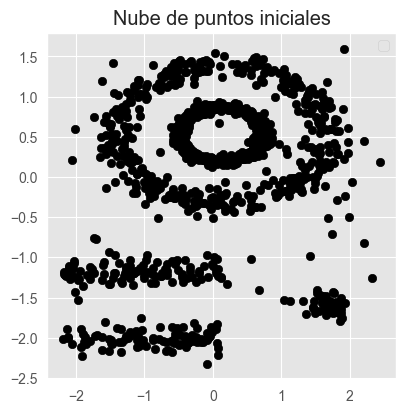

In [21]:
# Visualizado de datos
# ==============================================================================

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_scaled[:, 0],
    y = X_scaled[:, 1],
    c = 'black',
    marker    = 'o',
    edgecolor = 'black'
)
ax.legend()
ax.set_title('Nube de puntos iniciales');

In [23]:
# Modelo
# ==============================================================================
modelo_dbscan = DBSCAN(
    eps          = 0.2,
    min_samples  = 5,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X=X_scaled)

DBSCAN(eps=0.2)

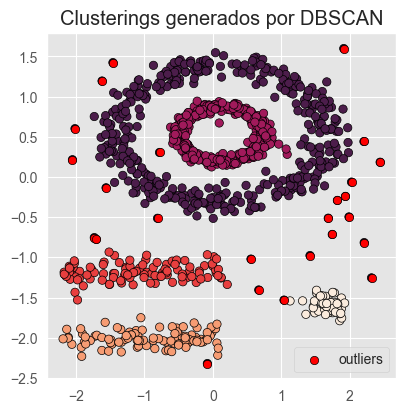

In [24]:
# Clasificación
# ==============================================================================
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_scaled[:, 0],
    y = X_scaled[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_scaled[labels == -1, 0],
    y = X_scaled[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN');

In [25]:
# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

Número de clusters encontrados: 5
Número de outliers encontrados: 25


Vamos a determinar una eps adecuada

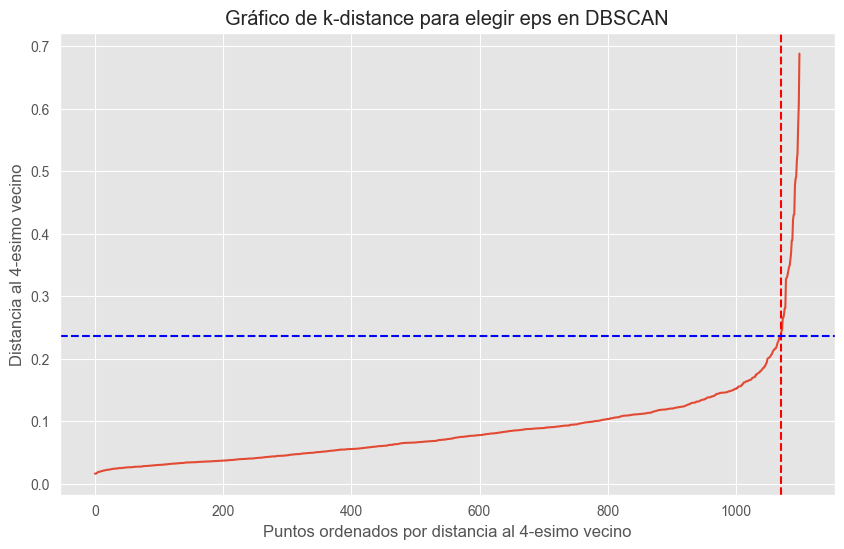

x_point=1070 y_value=0.23667785377389358


In [26]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

min_samples = 5

# Compute the nearest neighbors
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)

# Sort the distances
sorted_distances = np.sort(distances[:, min_samples-1], axis=0)

x_point = 1070
y_value = sorted_distances[x_point]  # Obtener el valor de la distancia para ese punto

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.xlabel('Puntos ordenados por distancia al {}-esimo vecino'.format(min_samples-1))
plt.ylabel('Distancia al {}-esimo vecino'.format(min_samples-1))
plt.title('Gráfico de k-distance para elegir eps en DBSCAN')

plt.axvline(x=x_point, color='r', linestyle='--')

# Dibujar la línea horizontal correspondiente en el eje Y
plt.axhline(y=y_value, color='b', linestyle='--')

plt.grid(True)
plt.show()

print(f'{x_point=} y_value={y_value}')

Vemos que una eps de aproximadamente eps=0.24 corresponde al codo en el gráfico anterior (no muy distinta de eps=0.2) que ya habíamos probado). Probemos entonces con eps=0.24

In [17]:
# Modelo
# ==============================================================================
modelo_dbscan = DBSCAN(
    eps          = y_value,
    min_samples  = 5,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X=X_scaled)

# Clasificación
# ==============================================================================
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_scaled[:, 0],
    y = X_scaled[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_scaled[labels == -1, 0],
    y = X_scaled[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN')

# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')





NameError: name 'DBSCAN' is not defined